## EECS 126 Project

This research aims to use the Markov Chain Monte-Carlo (MCMC) sampling method to achieve super-resolution image reconstruction. The goal of super-resolution image reconstruction is to construct a higher resolution image given one, potentially blurred and slighted tweaked, with lower resolution.

This could be very useful for enhancing images or being a preliminary step for other image processing such as image recognition. Similar to Markov-chain modeled text generation, image generation can be considered as a 2-dimensional Markov random field (MRF), where each pixel is conditionally independent from all other pixels except its neighbors.

In [5]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

img_height = 64
noise_std = 0.3

In [6]:
class ImageSR:
    def __init__(self,
                 width: int,
                 height: int,
                 observations: np.ndarray,
                 blurrings: np.ndarray,
                 noise_std: float,
                 inference_range: int = 2):
        """
        :param width: the desired width of the high-res image
        :param height: the desired height of the high-res image
        :param observations: the list of low-res images
        :param blurrings: the expected blurring and downsampling method for
            each observation
        :param noise_std: the standard deviation of the additive Gaussian noise
        :param inference_range: the range that we consider as influential to a
            point. For example, if inference_range = 2, we allow pixels marked
            with an 'x' to influence the point marked with a '#':
            o o x o o
            o x x x o
            x x # x x
            o x x x o
            o o x o o
        """
        # the size of high-res vector
        self.M = width * height
        # a list of low-res vectors
        self.ys = observations
        # the size of the low-res vector
        self.L = observations[0].shape[0]
        self.hs = blurrings
        self.gamma = inference_range
        # number of low-res vectors
        self.rho = self.ys.shape[0]
        self.sigma = noise_std

        # the neighborhood matrix
        self.C = np.zeros((self.M, self.M))
        for x1 in range(height):
            for y1 in range(width):
                for x2 in range(height):
                    for y2 in range(width):
                        i = x1 * width + y1
                        j = x2 * width + y2
                        if 0 < abs(x1 - x2) + abs(y1 - y2) <= inference_range:
                            self.C[i, j] = -1
        for i in range(self.M):
            self.C[i, i] = -np.sum(self.C[i])

        # the paper said lambda is a "positive weighting parameter"
        # is this a hyperparameter that we needs to grid-search for?
        # TODO: what is lambda?
        self.lmbda = 1.0

    def gibbs(self, num_samples=1000, convergence_time=800):
        zs = np.zeros((num_samples, self.M))
        zs[0] = np.random.rand(self.M)

        for i in range(1, num_samples):
            if i % (num_samples//100) == 0:
                print("Gibbs sample: generating the %d-th sample"%i)
            zs[i] = np.copy(zs[i - 1])
            n = np.random.randint(1, self.M)
            zs[i, n] = self.mu(zs[i - 1], n)
            if i % (num_samples//100) == 0:
                print("The generated %d-th sample looks like"%i)
                self.display_img_vec(zs[i,:])

        # The paper said we should take the average of the last num_samples - T samples
        # where T is the expected convergence time
        # I don't quite get it but we should take the average of the last few samples
        # instead of all them for sure
        # TODO: implement convergence time
        return np.mean(zs[convergence_time:], axis=0)


    def psi(self, x, n, i, k):
        result = self.ys[k, i]
        if i != n:
            result -= self.hs[k, i, i] * x[i]
        return result

    def phi(self, x, n):
        result = 0
        for s in range(self.M):
            if s != n:
                result += self.C[s, n] * x[s] + self.C[n, s] * x[s]
        return result

    def tau(self, x, n):
        result = 0
        for k in range(self.rho):
            for i in range(self.L):
                result += (self.hs[k, i, n] / self.sigma) ** 2
        return 1 / (result + self.lmbda * self.C[n, n])

    def mu(self, x, n):
        result = 0
        for k in range(self.rho):
            for i in range(self.L):
                result += self.psi(x, n, i, k) * self.hs[k, i, n] / (self.sigma ** 2)
        return self.tau(x, n) / 2 * (2 * result - self.lmbda * self.phi(x, n))
    
    def display_img_vec(self, img_vec, img_shape=(img_height, img_height)):
        img = img_vec.reshape(img_shape)
        plt.imshow(img, cmap='gray')
        plt.show()
        

In [7]:
#test: blurred berkeley
def genereate_blurred_picture(original_pic, noise_mean=0, noise_std=noise_std):
    rand_vector = np.random.normal(noise_mean, noise_std, original_pic.shape)
    return original_pic + rand_vector

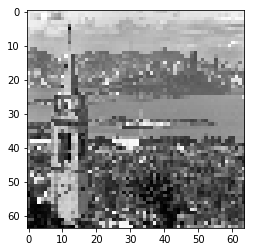

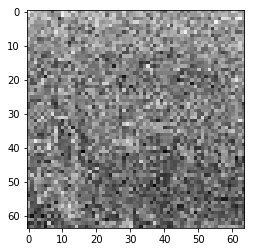

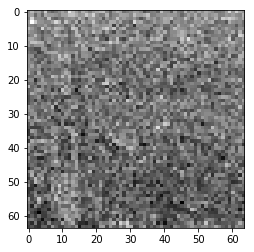

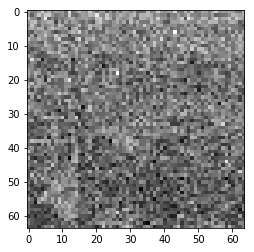

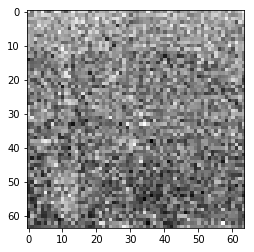

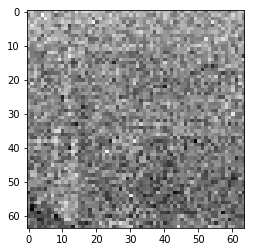

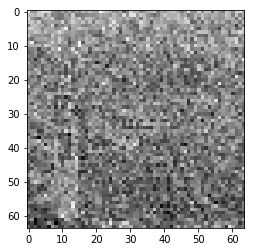

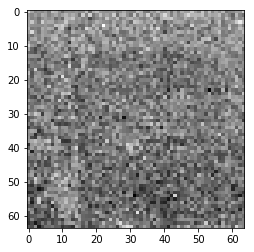

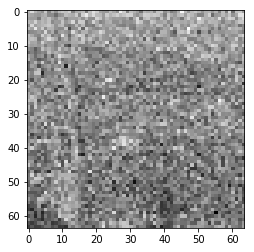

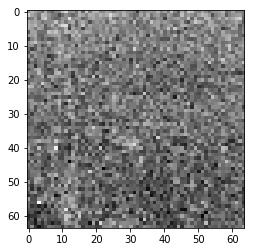

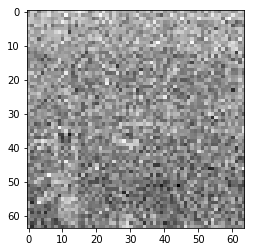

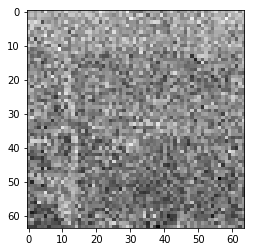

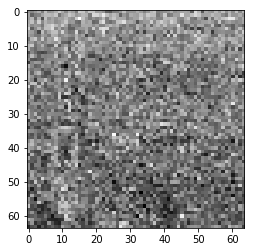

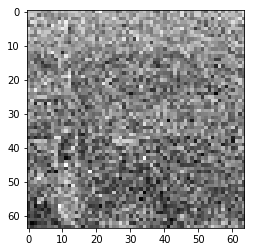

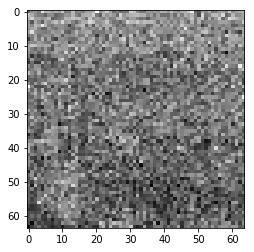

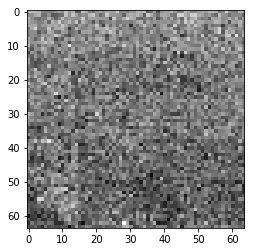

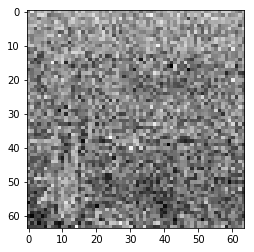

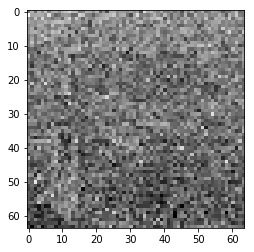

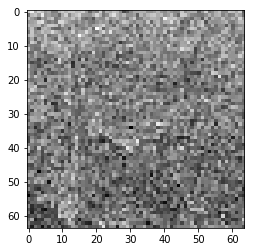

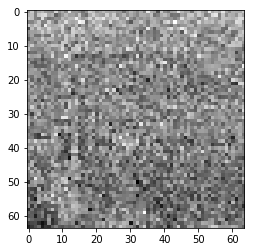

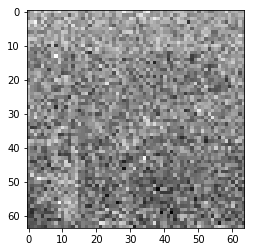

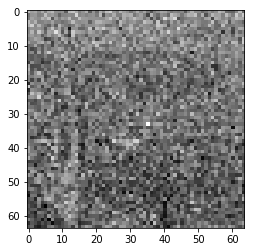

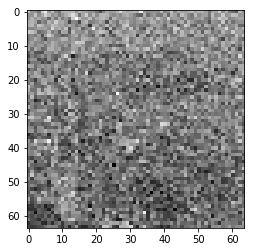

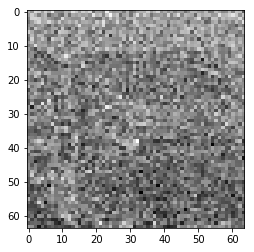

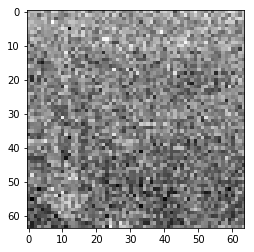

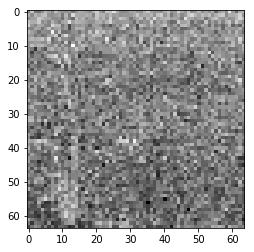

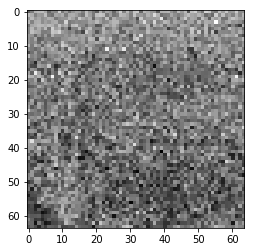

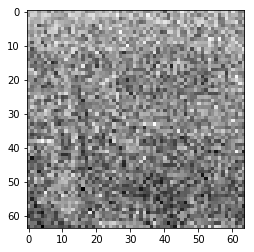

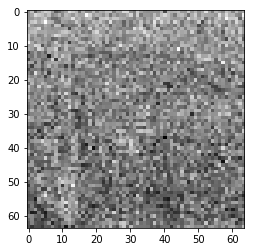

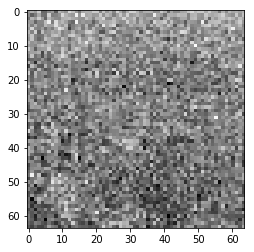

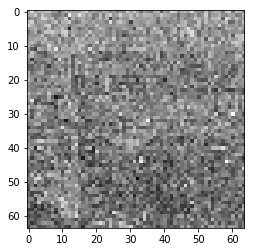

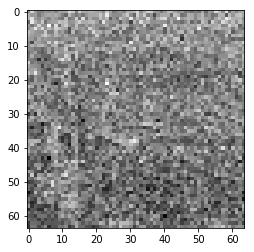

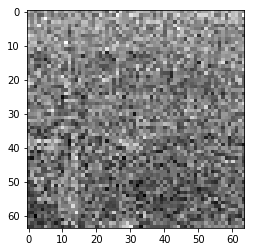

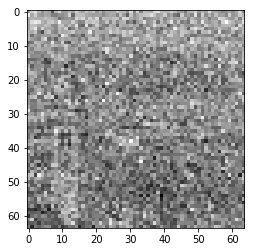

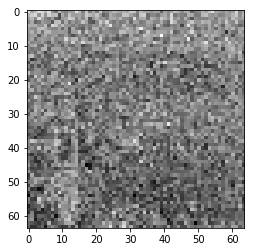

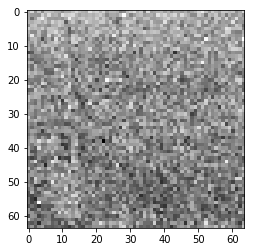

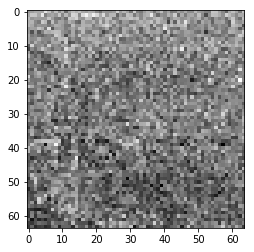

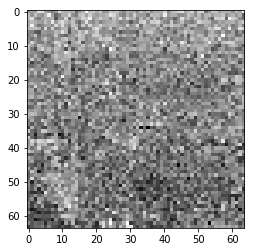

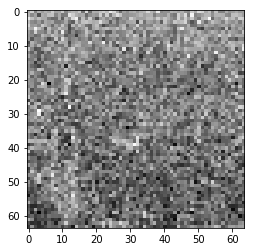

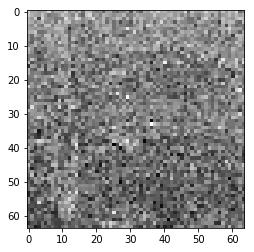

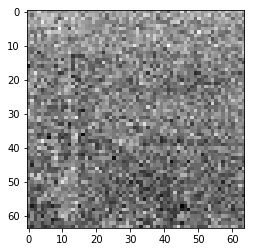

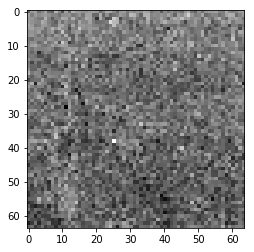

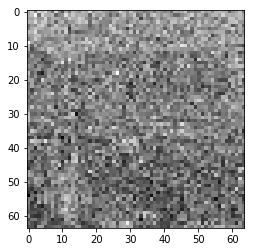

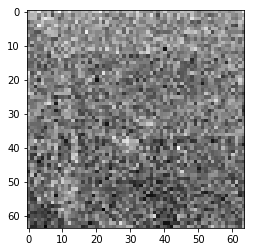

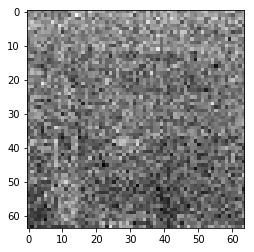

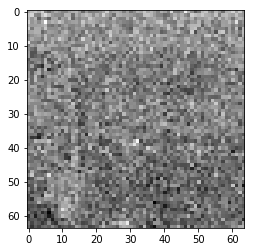

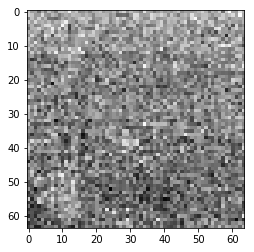

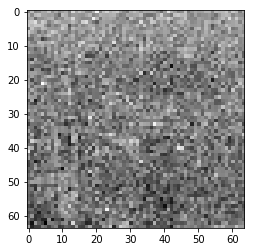

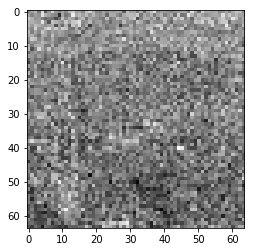

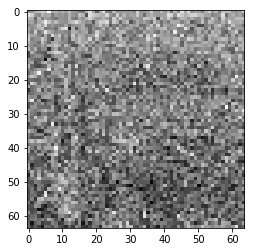

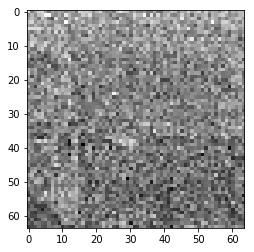

In [8]:
img = cv.resize(cv.imread('berkeley.jpg', cv.IMREAD_GRAYSCALE)/255.0, (img_height,img_height))
img_vec = img.reshape(img_height**2)
ImageSR.display_img_vec(None, img_vec)
num_observations = 50
observations = np.zeros((num_observations, img_height**2))
for i in range(num_observations):
    blurred_img = genereate_blurred_picture(img_vec)
    observations[i,:] = blurred_img
    ImageSR.display_img_vec(None, blurred_img)
blurrings = np.zeros((num_observations, img_height**2, img_height**2))
for i in range(num_observations):
    blurrings[i] = np.eye(img_height**2)

In [9]:
img_sr = ImageSR(img_height, img_height, observations, blurrings, noise_std)

Gibbs sample: generating the 150-th sample
The generated 150-th sample looks like


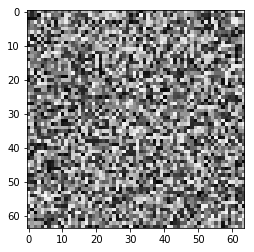

Gibbs sample: generating the 300-th sample
The generated 300-th sample looks like


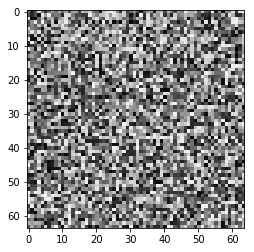

Gibbs sample: generating the 450-th sample
The generated 450-th sample looks like


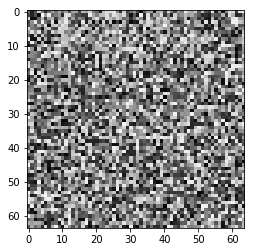

Gibbs sample: generating the 600-th sample
The generated 600-th sample looks like


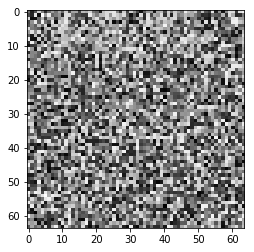

Gibbs sample: generating the 750-th sample
The generated 750-th sample looks like


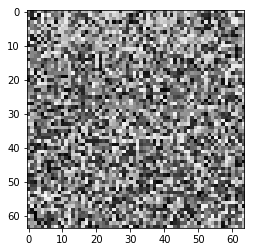

Gibbs sample: generating the 900-th sample
The generated 900-th sample looks like


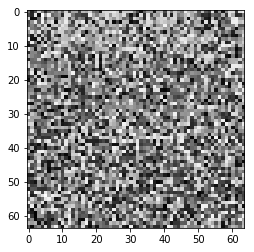

Gibbs sample: generating the 1050-th sample
The generated 1050-th sample looks like


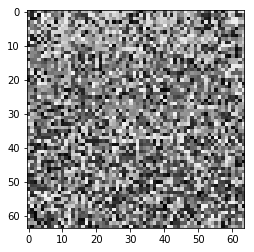

Gibbs sample: generating the 1200-th sample
The generated 1200-th sample looks like


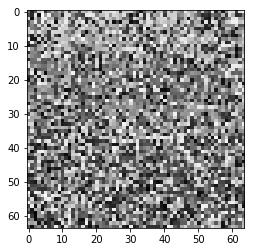

Gibbs sample: generating the 1350-th sample
The generated 1350-th sample looks like


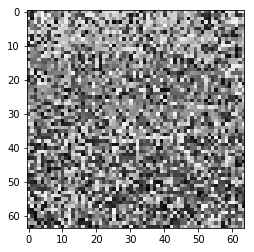

Gibbs sample: generating the 1500-th sample
The generated 1500-th sample looks like


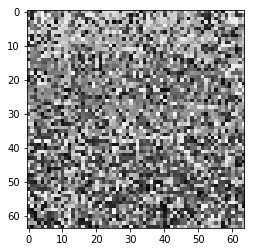

Gibbs sample: generating the 1650-th sample
The generated 1650-th sample looks like


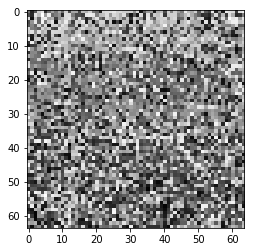

Gibbs sample: generating the 1800-th sample
The generated 1800-th sample looks like


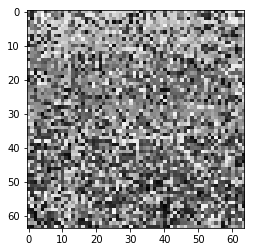

Gibbs sample: generating the 1950-th sample
The generated 1950-th sample looks like


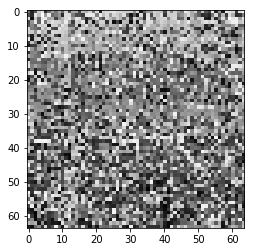

Gibbs sample: generating the 2100-th sample
The generated 2100-th sample looks like


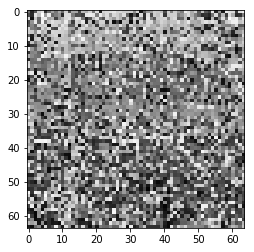

Gibbs sample: generating the 2250-th sample
The generated 2250-th sample looks like


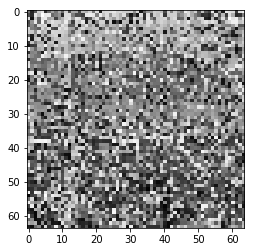

Gibbs sample: generating the 2400-th sample
The generated 2400-th sample looks like


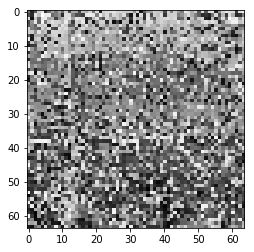

Gibbs sample: generating the 2550-th sample
The generated 2550-th sample looks like


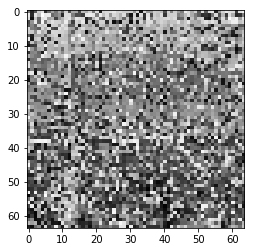

Gibbs sample: generating the 2700-th sample
The generated 2700-th sample looks like


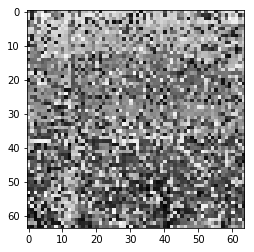

Gibbs sample: generating the 2850-th sample
The generated 2850-th sample looks like


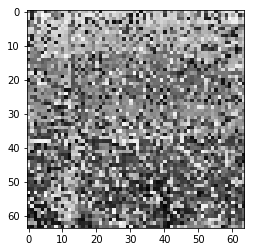

Gibbs sample: generating the 3000-th sample
The generated 3000-th sample looks like


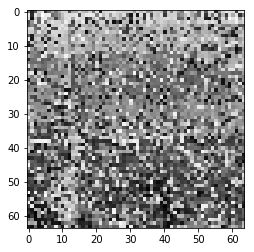

Gibbs sample: generating the 3150-th sample
The generated 3150-th sample looks like


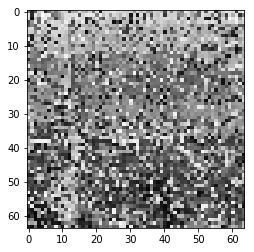

Gibbs sample: generating the 3300-th sample
The generated 3300-th sample looks like


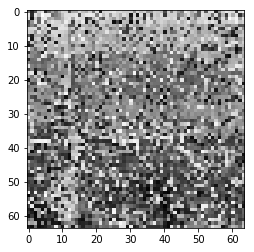

Gibbs sample: generating the 3450-th sample
The generated 3450-th sample looks like


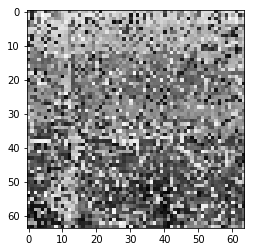

Gibbs sample: generating the 3600-th sample
The generated 3600-th sample looks like


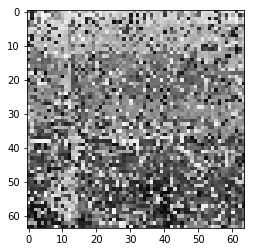

Gibbs sample: generating the 3750-th sample
The generated 3750-th sample looks like


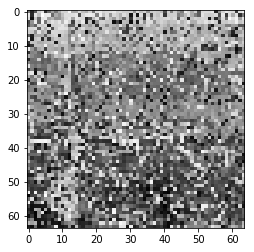

Gibbs sample: generating the 3900-th sample
The generated 3900-th sample looks like


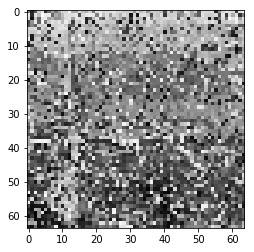

Gibbs sample: generating the 4050-th sample
The generated 4050-th sample looks like


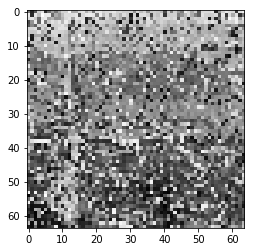

Gibbs sample: generating the 4200-th sample
The generated 4200-th sample looks like


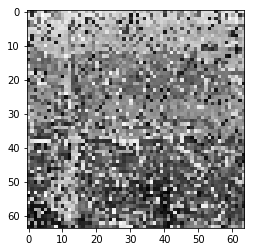

Gibbs sample: generating the 4350-th sample
The generated 4350-th sample looks like


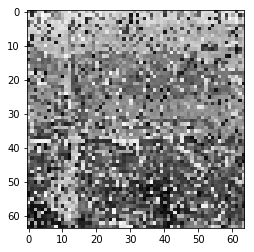

Gibbs sample: generating the 4500-th sample
The generated 4500-th sample looks like


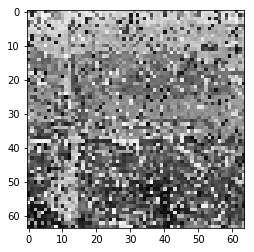

Gibbs sample: generating the 4650-th sample
The generated 4650-th sample looks like


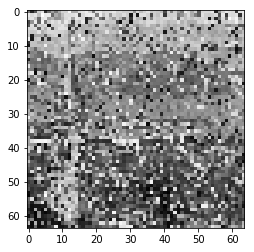

Gibbs sample: generating the 4800-th sample
The generated 4800-th sample looks like


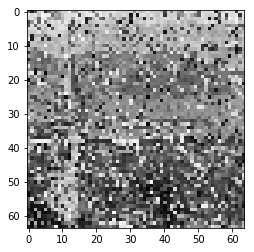

Gibbs sample: generating the 4950-th sample
The generated 4950-th sample looks like


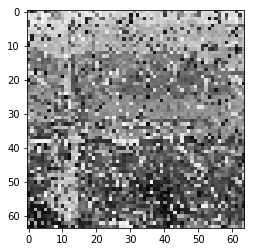

Gibbs sample: generating the 5100-th sample
The generated 5100-th sample looks like


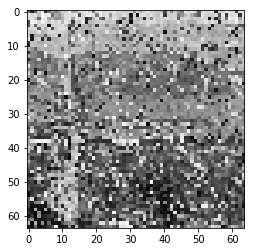

Gibbs sample: generating the 5250-th sample
The generated 5250-th sample looks like


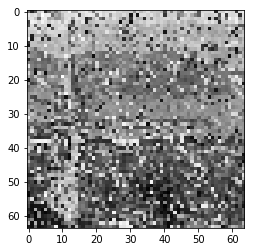

Gibbs sample: generating the 5400-th sample
The generated 5400-th sample looks like


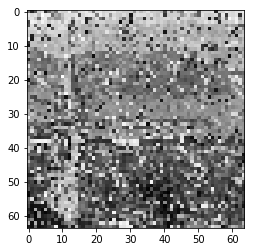

Gibbs sample: generating the 5550-th sample
The generated 5550-th sample looks like


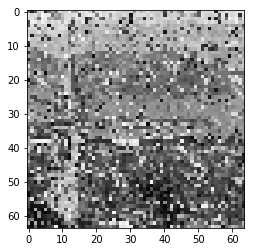

Gibbs sample: generating the 5700-th sample
The generated 5700-th sample looks like


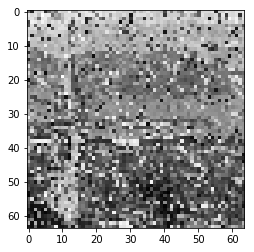

Gibbs sample: generating the 5850-th sample
The generated 5850-th sample looks like


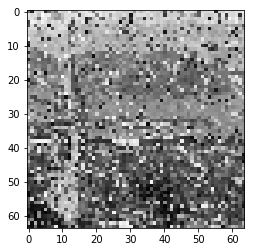

Gibbs sample: generating the 6000-th sample
The generated 6000-th sample looks like


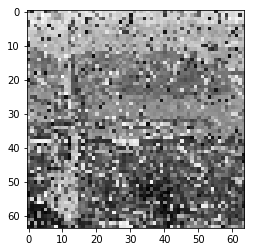

Gibbs sample: generating the 6150-th sample
The generated 6150-th sample looks like


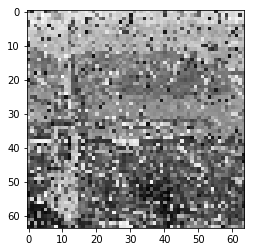

Gibbs sample: generating the 6300-th sample
The generated 6300-th sample looks like


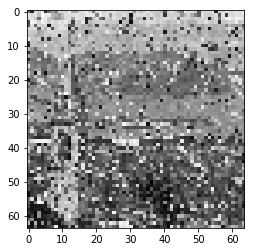

Gibbs sample: generating the 6450-th sample
The generated 6450-th sample looks like


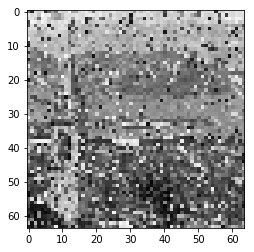

Gibbs sample: generating the 6600-th sample
The generated 6600-th sample looks like


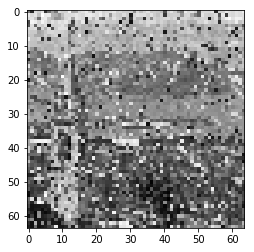

Gibbs sample: generating the 6750-th sample
The generated 6750-th sample looks like


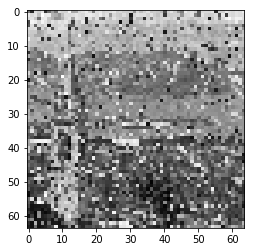

Gibbs sample: generating the 6900-th sample
The generated 6900-th sample looks like


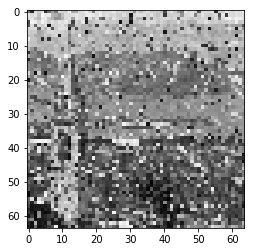

Gibbs sample: generating the 7050-th sample
The generated 7050-th sample looks like


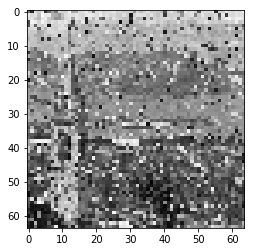

Gibbs sample: generating the 7200-th sample
The generated 7200-th sample looks like


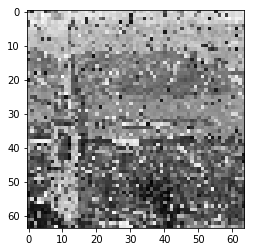

Gibbs sample: generating the 7350-th sample
The generated 7350-th sample looks like


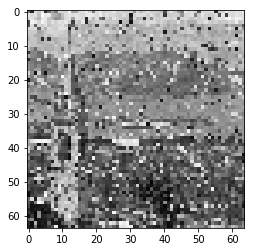

Gibbs sample: generating the 7500-th sample
The generated 7500-th sample looks like


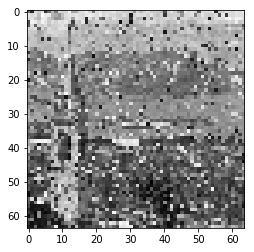

Gibbs sample: generating the 7650-th sample
The generated 7650-th sample looks like


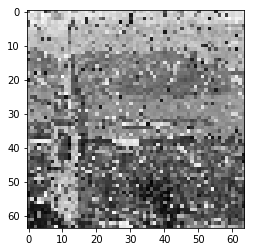

Gibbs sample: generating the 7800-th sample
The generated 7800-th sample looks like


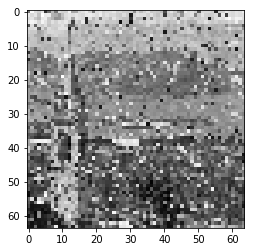

Gibbs sample: generating the 7950-th sample
The generated 7950-th sample looks like


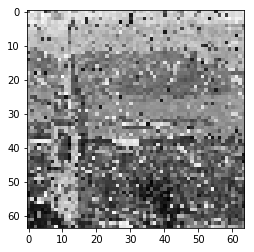

Gibbs sample: generating the 8100-th sample
The generated 8100-th sample looks like


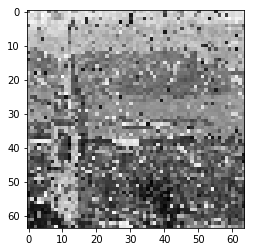

Gibbs sample: generating the 8250-th sample
The generated 8250-th sample looks like


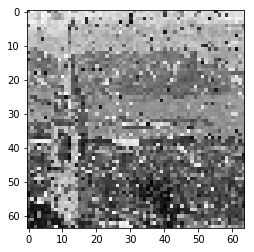

Gibbs sample: generating the 8400-th sample
The generated 8400-th sample looks like


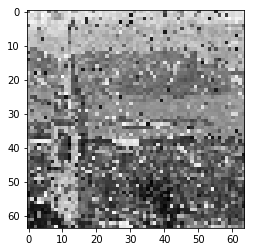

Gibbs sample: generating the 8550-th sample
The generated 8550-th sample looks like


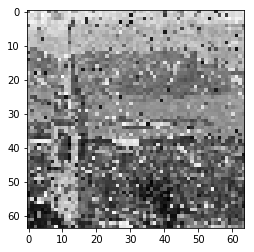

Gibbs sample: generating the 8700-th sample
The generated 8700-th sample looks like


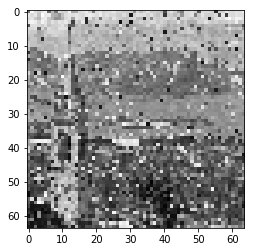

Gibbs sample: generating the 8850-th sample
The generated 8850-th sample looks like


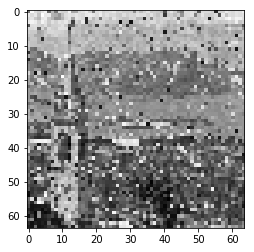

Gibbs sample: generating the 9000-th sample
The generated 9000-th sample looks like


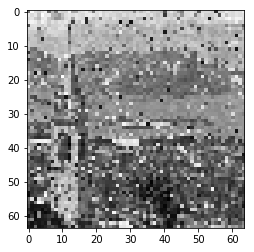

Gibbs sample: generating the 9150-th sample
The generated 9150-th sample looks like


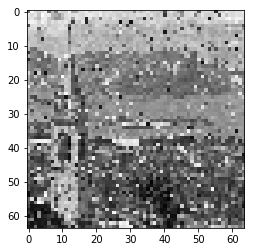

Gibbs sample: generating the 9300-th sample
The generated 9300-th sample looks like


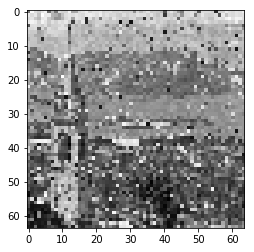

Gibbs sample: generating the 9450-th sample
The generated 9450-th sample looks like


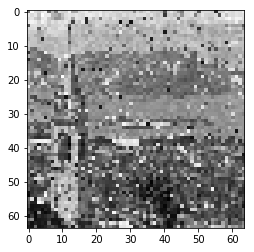

Gibbs sample: generating the 9600-th sample
The generated 9600-th sample looks like


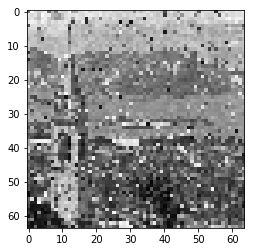

In [ ]:
tmp = img_sr.gibbs(num_samples=15000)

In [ ]:
ImageSR.display_img_vec(None, tmp)